In [1]:
import torch
import tensorflow as tf

/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [55]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data().batch
x_train, x_test = x_train / 255.0, x_test / 255.0

In [71]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [72]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [74]:
model.fit(x_train, y_train, epochs=5, batch_size=16)

Epoch 1/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0799 - accuracy: 0.9748
Epoch 2/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0678 - accuracy: 0.9775
Epoch 3/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0605 - accuracy: 0.9809
Epoch 4/5
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0562 - accuracy: 0.9814
Epoch 5/5
3750/3750 [==============================] - 6s 2ms/step - loss: 0.0505 - accuracy: 0.9834


In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [78]:
from torch import nn
import pytorch_lightning as pl
import torchvision
import torch
import statistics
import os
import numpy as np

In [79]:
class CustomSequential(nn.Module):
    def __init__(self, config):
        super(CustomSequential, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(128, 10))
    def forward(self, input):
        if isinstance(input, np.ndarray):
            input = torch.from_numpy(input).float()
        return self.model(input)

    def predict(self, input):
        if isinstance(input, np.ndarray):
            input = torch.from_numpy(input).float()
        return self.model(input)

class NumberNet(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.model = CustomSequential(config)
        # not including softmax because it's included in the Cross Entropy Loss Function
        self.criterion = nn.CrossEntropyLoss()
        self.config = config
        self.test_loss = None
        self.test_accuracy = None
        self.accuracy = pl.metrics.Accuracy()

    def train_dataloader(self):
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST("~/resiliency/", train=True,
                                                                      transform=torchvision.transforms.ToTensor(),
                                                                      target_transform=None, download=True),
                                           batch_size=int(self.config['batch_size']), num_workers=4, shuffle=False)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST("~/resiliency/", train=False,
                                                                      transform=torchvision.transforms.ToTensor(),
                                                                      target_transform=None, download=True),
                                           batch_size=int(self.config['batch_size']), num_workers=4)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['learning_rate'], eps=self.config['adam_epsilon'])
        return optimizer

    def forward(self, x):
        return self.model(x)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        return {'forward': self.forward(x), 'expected': y}

    def training_step_end(self, outputs):
        # only use when  on dp
        loss = self.criterion(outputs['forward'], outputs['expected'])
        logs = {'train_loss': loss}
        return {'loss': loss, 'logs': logs}

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        return {'forward': self.forward(x), 'expected': y}

    def test_step_end(self, outputs):
        loss = self.criterion(outputs['forward'], outputs['expected'])
        accuracy = self.accuracy(outputs['forward'], outputs['expected'])
        logs = {'test_loss': loss, 'test_accuracy': accuracy}
        return {'test_loss': loss, 'logs': logs, 'test_accuracy': accuracy}

    def test_epoch_end(self, outputs):
        loss = []
        for x in outputs:
            loss.append(float(x['test_loss']))
        avg_loss = statistics.mean(loss)
        tensorboard_logs = {'test_loss': avg_loss}
        self.test_loss = avg_loss
        accuracy = []
        for x in outputs:
            accuracy.append(float(x['test_accuracy']))
        avg_accuracy = statistics.mean(accuracy)
        self.test_accuracy = avg_accuracy
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs, 'avg_test_accuracy': avg_accuracy}


def mnist_pt_objective(config):
    torch.manual_seed(0)
    model = NumberNet(config)
    try:
        trainer = pl.Trainer(max_epochs=config['epochs'], gpus=[0])
    except:
        print("WARNING: training on CPU only, GPU[0] not found.")
        trainer = pl.Trainer(max_epochs=config['epochs'])
    trainer.fit(model)
    trainer.test(model)
    return model.test_accuracy, model.model


if __name__ == "__main__":
    test_config = {'batch_size': 64, 'learning_rate': .001, 'epochs': 1, 'dropout': 0.5, 'adam_epsilon': 1e-7}
    res = mnist_pt_objective(test_config)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | CustomSequential | 101 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Extracting /Users/mzvyagin/resiliency/MNIST/raw/train-images-idx3-ubyte.gz to /Users/mzvyagin/resiliency/MNIST/raw


Extracting /Users/mzvyagin/resiliency/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/mzvyagin/resiliency/MNIST/raw



Extracting /Users/mzvyagin/resiliency/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/mzvyagin/resiliency/MNIST/raw


Extracting /Users/mzvyagin/resiliency/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/mzvyagin/resiliency/MNIST/raw
Processing...
Done!



/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Saving latest checkpoint..


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': 0.9366042883532821,
 'avg_test_loss': 0.21348377091181317,
 'test_loss': 0.21348377091181317}
--------------------------------------------------------------------------------



In [80]:
d = torchvision.datasets.MNIST("~/resiliency/", train=True,
                                                                      transform=torchvision.transforms.ToTensor(),
                                                                      target_transform=None, download=True)

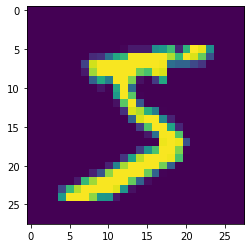

In [86]:
plt.imshow(d[0][0].squeeze())

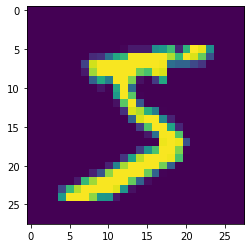

In [87]:
plt.imshow(x_train[0])